<a href="https://colab.research.google.com/github/MrGrayCode/AutoEncoders/blob/main/Vanilla_Auto_Encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [49]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.optim import Adam
from torch.nn import Module
import torch.nn.functional as F
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision.transforms import transforms
import numpy as np
import random

import matplotlib.pyplot as plt

# Load data

This notebook will be using Fashion MNIST for testing

In [8]:
transform = transforms.Compose([transforms.ToTensor()])

In [9]:
training_set = FashionMNIST('./data',download=True,train=True,transform = transform)
test_set = FashionMNIST('./data',download=True,train=False,transform = transform)

In [10]:
train_loader = DataLoader(training_set,batch_size=64,shuffle=True)
test_loader = DataLoader(test_set,batch_size=16,shuffle=False)

# Utils

In [63]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(npimg.transpose(1,2,0))
    plt.axis('off')

# Display a batch of images

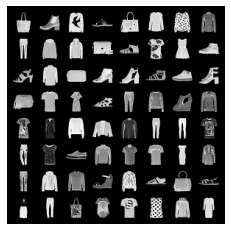

In [64]:
data_iter = iter(train_loader)
images,_ = data_iter.next()

imshow(torchvision.utils.make_grid(images,8,8))

# Define the AutoEncoder

In [45]:
class AutoEncoder(Module):
    def __init__(self,bottleneck_size):
        super(AutoEncoder, self).__init__()

        # convolutions
        self.conv1 = nn.Conv2d(1,8,4,padding = 1,stride=2)
        self.conv2 = nn.Conv2d(8,16,4,padding = 1,stride=2)
        # deconvolutions
        self.conv_t1 = nn.ConvTranspose2d(16,8,2, stride = 2)
        self.conv_t2 = nn.ConvTranspose2d(8,1,2, stride=2)

        # batch norms
        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn_t1 = nn.BatchNorm2d(8)

        # downsample
        self.downsample = nn.MaxPool2d((2,2))
        # upsample
        self.upsample = nn.Upsample(scale_factor=2)
        # fully connected layer
        self.fc_encoder = nn.Linear(16*7*7,bottleneck_size)
        self.fc_decoder = nn.Linear(bottleneck_size,16*7*7)
    
    def encoder(self,image):
 
        code = F.relu(self.bn1(self.conv1(image)))
        code = F.relu(self.bn2(self.conv2(code)))
        # linearize the feature map and use FC layer
        code = code.view(image.shape[0], 16*7*7)
        code = self.fc_encoder(code)
        return code
    
    def decoder(self,code):
        x = self.fc_decoder(code)
        # reshape for decoding
        x = x.view(code.shape[0],16,7,7)
        decoded_image = F.relu(self.bn_t1(self.conv_t1(x)))
        decoded_image = self.conv_t2(decoded_image)                         

        return decoded_image
    
    def forward(self,image):

        # get batch size
        batch_size = image.shape[0]
        # encode image
        code = self.encoder(image)
        # decode image
        decoded_image = self.decoder(code)
        decoded_image = torch.sigmoid(decoded_image)
        
        return decoded_image

# Training

In [24]:
# use GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [47]:
def reconstruction_loss(input,target):
    recon_loss = ((input-target)**2).mean()
    return recon_loss

epochs = 50 

bottleneck_size = 16 

autoencoder = AutoEncoder(bottleneck_size).to(device)

optimizer = Adam(autoencoder.parameters(), lr = 1e-3)

for ep in range(epochs):
    train_loss = 0.0
    val_loss = 0.0
    num_iterations = 0

    autoencoder.train()
    for i,data in enumerate(train_loader):
        num_iterations += 1

        input, _ = data
        input = input.to(device)
        target = input.to(device)
        # set gradients to zero
        optimizer.zero_grad()
        # forward pass to get output
        output = autoencoder(input)
        # calculate loss
        loss = reconstruction_loss(output, target)
        # backpropogate loss
        loss.backward()
        optimizer.step()
        # update loss
        train_loss += loss
    train_loss /= num_iterations
    num_iterations = 0
    
    autoencoder.eval()
    for i,data in enumerate(test_loader):
        num_iterations += 1
 =
        with torch.no_grad():
            input, _ = data
            input = input.to(device)
            target = input.to(device)

            # get output
            output = autoencoder(input)
            # calculate validation loss
            loss = reconstruction_loss(output, target)
            # update loss
            val_loss += loss
    val_loss /= num_iterations
    # print some metrics every 10 epochs
    if(ep%10==9):
        print("[{}/{}] Train Loss: {:.3f} Validation Loss: {:.3f}".format(ep+1,epochs,train_loss,val_loss))

[10/50] Train Loss: 0.014 Validation Loss: 0.014
[20/50] Train Loss: 0.013 Validation Loss: 0.013
[30/50] Train Loss: 0.013 Validation Loss: 0.013
[40/50] Train Loss: 0.013 Validation Loss: 0.013
[50/50] Train Loss: 0.013 Validation Loss: 0.012


# Results

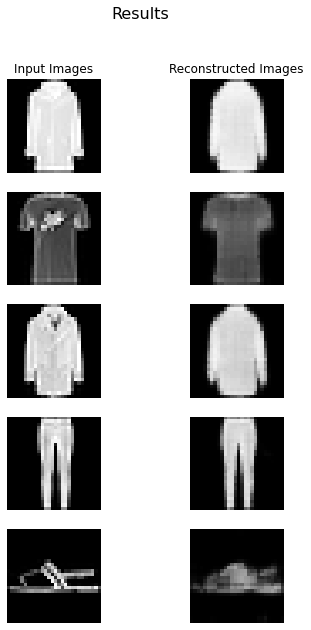

In [77]:
# sample 5 random images
random_images = random.sample(list(training_set),5)


# testing on MNIST data
plt.figure(figsize=(6,10))
plt.suptitle("Results",fontsize=16)
for i in range(5):
  input,_ = random_images[i]
  input = input.unsqueeze(0)
  input = input.to(device)
  output = autoencoder(input)
  # convert data from torch to numpy
  output = output.cpu().detach()[0]
  # transpose image to display
  plt.subplot(5,2,2*i+1)
  if(i==0):
    plt.title('Input Images')
  plt.axis('off')
  imshow(torchvision.utils.make_grid(input.cpu(),8,8))
  plt.subplot(5,2,2*i+2)
  if(i==0):
    plt.title('Reconstructed Images')
  plt.axis('off')
  imshow(torchvision.utils.make_grid(output,8,8))